# Apache Airflow for building pipeline
In the field of Data Science, a data pipeline usually represents a system that ingests, processes, analyzes data.  Sometimes a pipeline also fits and evaluates machine learning models and produce predictions.  As I have came across quite a bit of job postings that ask for experience in building data pipelines with Apache Airflow, I decided to give it a try and increase my own competency.  

Apache Airflow is an open source pipeline building library that all the coding can be based on Python.  Since I mostly practice data science in Python, building pipelines with Airflow becomes a great option for me.

## Project goal
As the purpose is building a data pipeline, I want to dig out something interesting from open data source.  As social media has been a major way of communications, my idea is to cross-analyze Tweeter messages and other societal or environmental factors.

For example, it'll be interesting to see if human communications are affected by the weather, or if results of sports games spur more discussion than government policies do.

As this idea involves multiple data sources and various areas in machine learning, I try to lay out the plan of attack in different phases:  
- Phase 1: Ingest and aggregate weather data.  
    I'm planning to use the API of OpenWeatherMap to get region specific weather data.  Thankfully, OpenWeatherMap provides free-tier of service that allows 1M api calls per month, which suits my requirement very well
    
- Phase 2: Ingest Tweeter data and perform topic modeling.  
    Tweeter also provides free-tier API registration and is suitable for my needs.  For now, I am planning to do topics modeling using Gensim to find the trend of subject matters in people's tweets.  
    
- Phase 3: Ingest news feeds and perform topic modeling.  
    As I'll start by focusing on Canadian news, CBC has RSS feeds to be used.  I am interested in comparing the popular topics of Canadian news with the hot topics on Tweeter.

- Phase 4: Semantic analysis on Tweeter messages.  
    After the trend has been found, I am also interested in finding whether semantics of Tweeter messages do get affected by the weather and the news.

## Phase 1
Let's start by building the skeleton of a functional data pipeline for ingesting and processing weather data:
- Apache Airflow can be installed by entering `conda install -c conda-forge airflow` in the terminal
- Airflow provides an [official introduction to some basic concept of pipeline construction](https://airflow.apache.org/docs/stable/tutorial.html)

> First, we create a file called `AIRFLOW_HOME/dags/my_dag.py`.  In the beginning, import some useful libraries.

In [1]:
import requests
import os
import pandas as pd
import json
from datetime import datetime, date, time
import re

> Create a dictionary for cities I'm interested in.  Here we have only 3 cities for easier troubleshooting.
```python
default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2020, 9, 1),
    'email_on_failure': False,
    'email_on_retry': False,
    'retries': 1,
    'retry_delay': timedelta(seconds = 5)
}
cityIds = {
    'Burnaby': 5911606,
    'Vancouver': 6173331,
    'Richmond': 6122085
}
```

In [2]:
cityIds = {
    'Burnaby': 5911606,
    'Vancouver': 6173331,
    'Richmond': 6122085
}

In [22]:
city, timestamp, condition, temperature, humidity, visibility, cloudiness = \
    list(), list(), list(), list(), list(), list(), list()
absZero = -273.15
t = datetime.now()

for name, cityId in cityIds.items():
    w = requests.get(f"http://api.openweathermap.org/data/2.5/weather?id={cityId}&appid={os.environ['OWM_KEY']}") \
        .json()
    city.append(w['name'])
    timestamp.append(t)
    condition.append(w['weather'][0]['main'].lower())
    temperature.append(w['main']['temp'] + absZero)
    humidity.append(w['main']['humidity'])
    visibility.append(w['visibility'])
    cloudiness.append(w['clouds']['all'])
    
weathers = pd.DataFrame({
        'city': city,
        'timestamp': timestamp,
        'condition': condition, 
        'temperature': temperature, 
        'humidity': humidity, 
        'visibility': visibility, 
        'cloudiness': cloudiness
    })
weathers

,city,timestamp,condition,temperature,humidity,visibility,cloudiness
0,Burnaby,2020-09-01 21:33:49.684291,clouds,17.78,77,10000,75
1,Vancouver,2020-09-01 21:33:49.684291,clouds,17.66,77,10000,75
2,Richmond,2020-09-01 21:33:49.684291,clouds,17.39,77,10000,75


In [6]:
# t = datetime.now().time()
weathers.to_csv(f"weathers_{t.date()}T{t.hour:02}-{t.minute:02}-{t.second:02}.csv", 
                index = False)

In [7]:
# import re
latestCsv = sorted([x for x in os.listdir() if re.findall(r"^weathers.*\.csv$", x)])[-1]
latestCsv

'weathers_2020-09-01T19-41-12.csv'

In [8]:
def read_csv_timestamp(path, cols = ['timestamp']):
    df = pd.read_csv(path)
    for col in cols:
        df[col] = df[col].apply(lambda x: datetime.fromisoformat(x))
    return df

In [9]:
newWeathers = read_csv_timestamp(latestCsv)
newWeathers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 7 columns):
city           3 non-null object
timestamp      3 non-null datetime64[ns]
condition      3 non-null object
temperature    3 non-null float64
humidity       3 non-null int64
visibility     3 non-null int64
cloudiness     3 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 296.0+ bytes


In [10]:
if not os.path.exists('all_weathers.csv'):
    allWeathers = pd.DataFrame({
            'city': list(),
            'timestamp': list(),
            'condition': list(), 
            'temperature': list(), 
            'humidity': list(), 
            'visibility': list(), 
            'cloudiness': list()
        })
else:
    allWeathers = read_csv_timestamp("all_weathers.csv")
allWeathers = allWeathers.append(newWeathers, ignore_index = True)
allWeathers.to_csv("all_weathers.csv", index = False)

In [11]:
allWeathers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
city           12 non-null object
timestamp      12 non-null datetime64[ns]
condition      12 non-null object
temperature    12 non-null float64
humidity       12 non-null float64
visibility     12 non-null float64
cloudiness     12 non-null float64
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 800.0+ bytes


In [12]:
import altair as alt
allWeathers = read_csv_timestamp("all_weathers.csv")
# allWeathers['date'] = pd.to_datetime(allWeathers['timestamp'].apply(lambda x: x.split(" ")[0]))
# allWeathers['date'] = pd.to_datetime(allWeathers['timestamp'].apply(lambda x: x.split(" ")[0]), 
#                                     format = '%Y-%m-%d')
# allWeathers['time'] = pd.to_datetime(allWeathers['timestamp'].apply(lambda x: x.split(" ")[1]),
#                                     format = '%H:%M:%S').dt.time
allWeathers['date'] = allWeathers['timestamp'].apply(lambda x: x.date())
allWeathers['time'] = allWeathers['timestamp'].apply(lambda x: x.time())
allWeathers

,city,timestamp,condition,temperature,humidity,visibility,cloudiness,date,time
0,Burnaby,2020-09-01 15:41:40.750786,clouds,22.85,64.0,10000.0,84.0,2020-09-01,15:41:40.750786
1,Vancouver,2020-09-01 15:41:40.750786,clouds,22.71,58.0,10000.0,67.0,2020-09-01,15:41:40.750786
2,Richmond,2020-09-01 15:41:40.750786,clouds,21.83,72.0,10000.0,20.0,2020-09-01,15:41:40.750786
3,Burnaby,2020-09-01 19:12:56.651464,clear,21.06,70.0,10000.0,1.0,2020-09-01,19:12:56.651464
4,Vancouver,2020-09-01 19:12:56.651464,clouds,21.08,69.0,10000.0,19.0,2020-09-01,19:12:56.651464
5,Richmond,2020-09-01 19:12:56.651464,clouds,21.11,69.0,10000.0,15.0,2020-09-01,19:12:56.651464
6,Burnaby,2020-09-01 19:39:58.809564,clouds,20.14,77.0,10000.0,75.0,2020-09-01,19:39:58.809564
7,Vancouver,2020-09-01 19:39:58.809564,clouds,20.06,77.0,10000.0,75.0,2020-09-01,19:39:58.809564
8,Richmond,2020-09-01 19:39:58.809564,clouds,19.97,77.0,10000.0,75.0,2020-09-01,19:39:58.809564
9,Burnaby,2020-09-01 19:41:12.481582,clouds,20.14,77.0,10000.0,75.0,2020-09-01,19:41:12.481582


In [13]:
allWeathers['date'][0]

datetime.date(2020, 9, 1)

In [14]:
allPivot = allWeathers.pivot_table(index = ['city', 'condition'], columns = 'time', values = 'temperature') \
            .reset_index()
allPivot

time,city,condition,15:41:40.750786,19:12:56.651464,19:39:58.809564,19:41:12.481582
0,Burnaby,clear,NaN,21.06,NaN,NaN
1,Burnaby,clouds,22.85,NaN,20.14,20.14
2,Richmond,clouds,21.83,21.11,19.97,19.97
3,Vancouver,clouds,22.71,21.08,20.06,20.06


In [15]:
del allPivot.columns.name
allPivot

,city,condition,15:41:40.750786,19:12:56.651464,19:39:58.809564,19:41:12.481582
0,Burnaby,clear,NaN,21.06,NaN,NaN
1,Burnaby,clouds,22.85,NaN,20.14,20.14
2,Richmond,clouds,21.83,21.11,19.97,19.97
3,Vancouver,clouds,22.71,21.08,20.06,20.06


In [16]:
idCols = ['city', 'condition']
allPivot.melt(
    id_vars = idCols,
    value_vars = [x for x in allPivot.columns if x not in idCols],
    var_name = 'timeee',
    value_name = 'tempr'
)

,city,condition,timeee,tempr
0,Burnaby,clear,15:41:40.750786,NaN
1,Burnaby,clouds,15:41:40.750786,22.85
2,Richmond,clouds,15:41:40.750786,21.83
3,Vancouver,clouds,15:41:40.750786,22.71
4,Burnaby,clear,19:12:56.651464,21.06
5,Burnaby,clouds,19:12:56.651464,NaN
6,Richmond,clouds,19:12:56.651464,21.11
7,Vancouver,clouds,19:12:56.651464,21.08
8,Burnaby,clear,19:39:58.809564,NaN
9,Burnaby,clouds,19:39:58.809564,20.14


In [17]:
allWeathers['time'] = allWeathers['time'].apply(lambda x: x.isoformat('seconds'))
allWeathers

,city,timestamp,condition,temperature,humidity,visibility,cloudiness,date,time
0,Burnaby,2020-09-01 15:41:40.750786,clouds,22.85,64.0,10000.0,84.0,2020-09-01,15:41:40
1,Vancouver,2020-09-01 15:41:40.750786,clouds,22.71,58.0,10000.0,67.0,2020-09-01,15:41:40
2,Richmond,2020-09-01 15:41:40.750786,clouds,21.83,72.0,10000.0,20.0,2020-09-01,15:41:40
3,Burnaby,2020-09-01 19:12:56.651464,clear,21.06,70.0,10000.0,1.0,2020-09-01,19:12:56
4,Vancouver,2020-09-01 19:12:56.651464,clouds,21.08,69.0,10000.0,19.0,2020-09-01,19:12:56
5,Richmond,2020-09-01 19:12:56.651464,clouds,21.11,69.0,10000.0,15.0,2020-09-01,19:12:56
6,Burnaby,2020-09-01 19:39:58.809564,clouds,20.14,77.0,10000.0,75.0,2020-09-01,19:39:58
7,Vancouver,2020-09-01 19:39:58.809564,clouds,20.06,77.0,10000.0,75.0,2020-09-01,19:39:58
8,Richmond,2020-09-01 19:39:58.809564,clouds,19.97,77.0,10000.0,75.0,2020-09-01,19:39:58
9,Burnaby,2020-09-01 19:41:12.481582,clouds,20.14,77.0,10000.0,75.0,2020-09-01,19:41:12


In [18]:
allWeathers.drop(columns = ['date'])

,city,timestamp,condition,temperature,humidity,visibility,cloudiness,time
0,Burnaby,2020-09-01 15:41:40.750786,clouds,22.85,64.0,10000.0,84.0,15:41:40
1,Vancouver,2020-09-01 15:41:40.750786,clouds,22.71,58.0,10000.0,67.0,15:41:40
2,Richmond,2020-09-01 15:41:40.750786,clouds,21.83,72.0,10000.0,20.0,15:41:40
3,Burnaby,2020-09-01 19:12:56.651464,clear,21.06,70.0,10000.0,1.0,19:12:56
4,Vancouver,2020-09-01 19:12:56.651464,clouds,21.08,69.0,10000.0,19.0,19:12:56
5,Richmond,2020-09-01 19:12:56.651464,clouds,21.11,69.0,10000.0,15.0,19:12:56
6,Burnaby,2020-09-01 19:39:58.809564,clouds,20.14,77.0,10000.0,75.0,19:39:58
7,Vancouver,2020-09-01 19:39:58.809564,clouds,20.06,77.0,10000.0,75.0,19:39:58
8,Richmond,2020-09-01 19:39:58.809564,clouds,19.97,77.0,10000.0,75.0,19:39:58
9,Burnaby,2020-09-01 19:41:12.481582,clouds,20.14,77.0,10000.0,75.0,19:41:12


In [19]:
alt.__version__

'3.2.0'

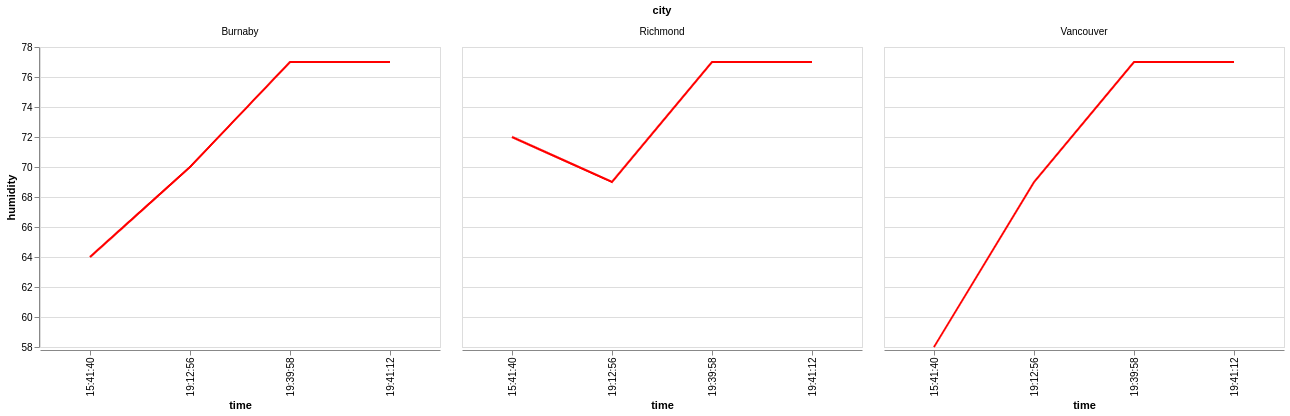

In [20]:
base = alt.Chart(allWeathers.drop(columns = ['date'])).encode(
    alt.X('time:N')
)
bar = base.mark_bar().encode(
    alt.Y("temperature:Q"),
    facet = alt.Facet('city:N')
)
line = base.mark_line(color = 'red').encode(
    alt.Y("humidity:Q",
          scale = alt.Scale(zero = False))
).facet(
    alt.Facet('city:N'),
    columns = 3
)
line

#     alt.X('Acceleration:Q',
#         scale=alt.Scale(zero=False)
#     ),
#     y='Horsepower:Q'
# )

In [21]:
line.save('test.png', scale_factor = 1.2)